## Sample mock P1D (from model, not sim)

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a given P1D model, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

In [2]:
# specify if you want to add high-resolution P1D (only working for Pedersen23)
add_hires=False
if add_hires:
    kmax_Mpc=8
else:
    kmax_Mpc=4

### Setup emulator

The emulator will be used both to make a mock, and in the likelihood 

In [3]:
# emulator=nn_emulator.NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx')
#emulator=nn_emulator.NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23')
emulator=gp_emulator.GPEmulator(training_set='Pedersen21',kmax_Mpc=kmax_Mpc)

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points


 /home/jchaves/miniconda3/envs/test/lib/python3.11/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


GPs optimised in 0.59 seconds


### Create mock P1D data

Use Lya theory to mimic mock data

In [4]:
data=mock_data.Mock_P1D(emulator=emulator,data_label="Chabanier2019")

In [5]:
# check if we also need mock extra_p1d
if add_hires:
    extra_data=mock_data.Mock_P1D(emulator=emulator,data_label="Karacayli2022")
else:
    extra_data=None

### Set free parameters and theory

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=0
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [7]:
theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)

In [8]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 7.4e-10 , 4.11e-09
ns = 0.965 , 0.68 , 1.32
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [9]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [10]:
# Set up sampler
n_burn_in=50
n_steps=500 
sampler = emcee_sampler.EmceeSampler(like=like,progress=True, nburnin=n_burn_in, nsteps=n_steps)

Created directory: /home/jchaves/Proyectos/projects/lya/cup1d/data/chains//chain_7
setup with  1  ranks,  81  walkers, and  500  steps
combined steps  44550 (should be close to  44000 )


In [11]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 7.4e-10 4.11e-09
ns 0.965 0.68 1.32


In [13]:

start = time.time()
sampler.run_sampler(n_burn_in,n_steps)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

set 81 walkers with 2 dimensions
emcee: Exception while calling your likelihood function:
  params: [0.54593523 0.4891487 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/jchaves/miniconda3/envs/test/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'int' object is not callable


TypeError: 'int' object is not callable

Mean values: [0.49839961344623207, 0.5014211061499277]


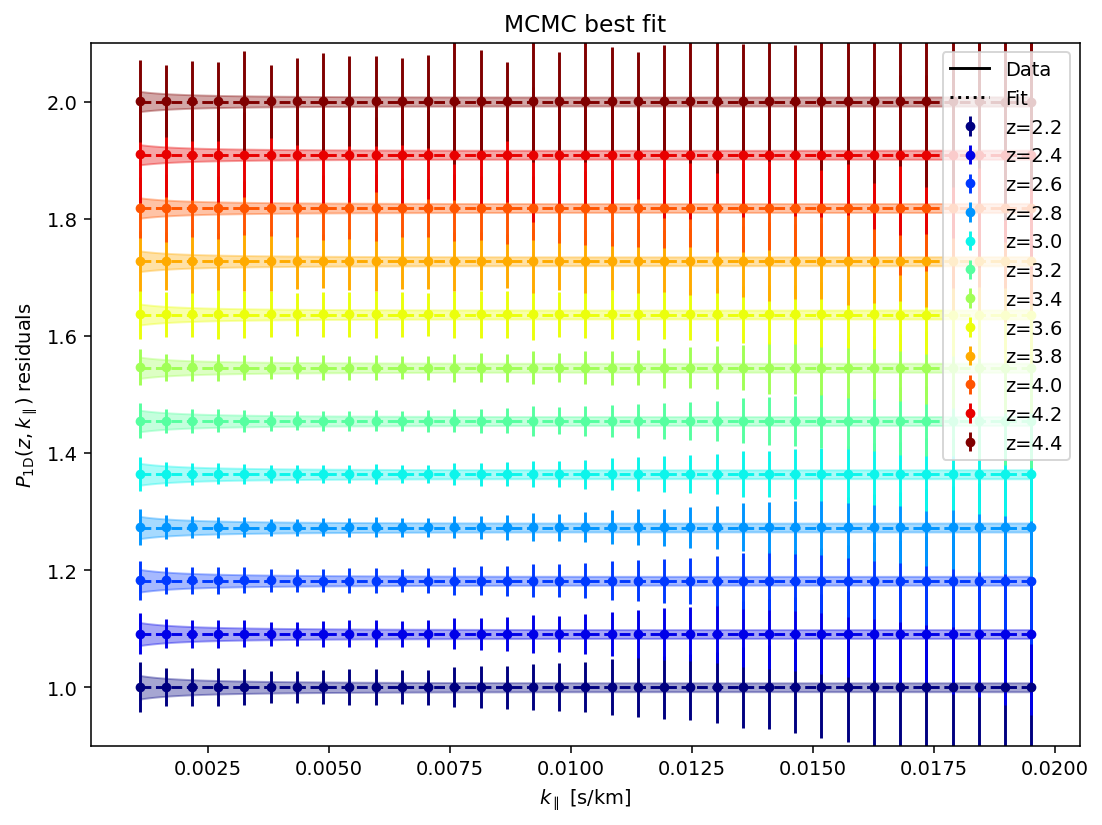

<Figure size 896x672 with 0 Axes>

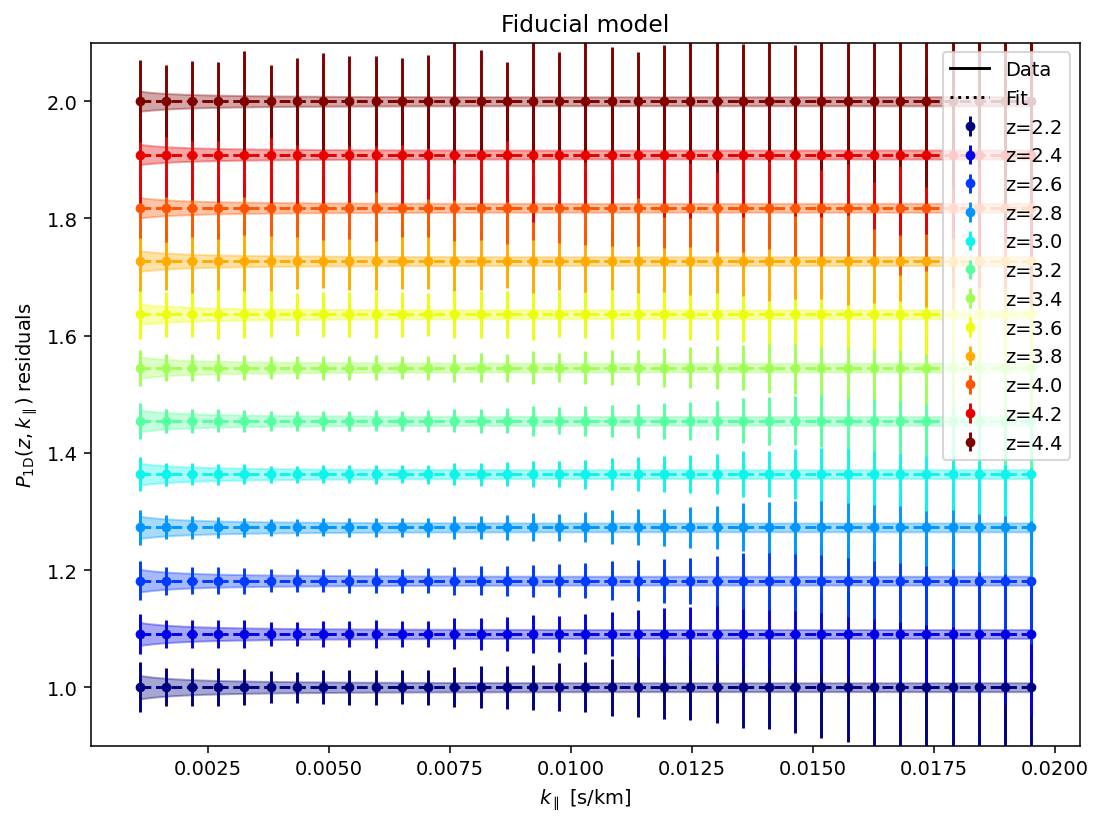

 /home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
 /home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
 /home/jchaves/miniconda3/envs/general/lib/python3.9/site-packages/numpy/lib/histograms.py:883: RuntimeWarning:invalid value encountered in divide


Can't plot corner


<Figure size 896x672 with 0 Axes>

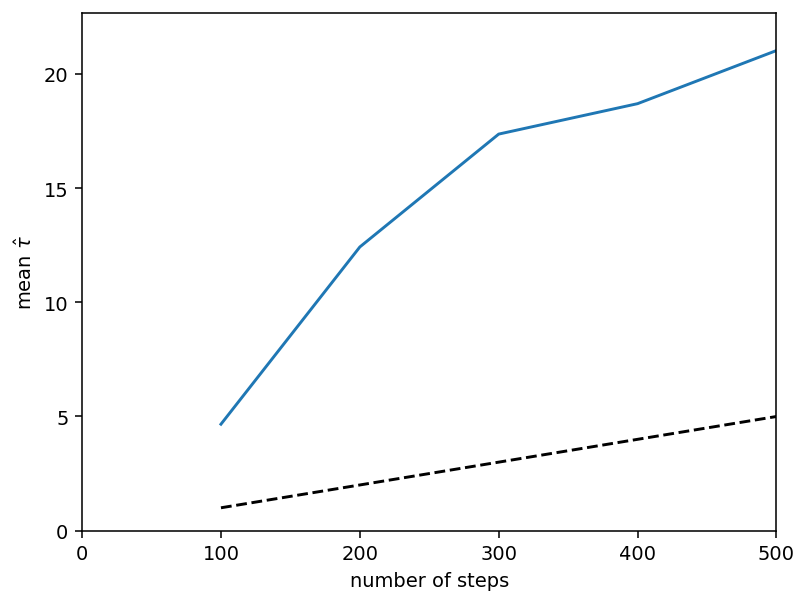

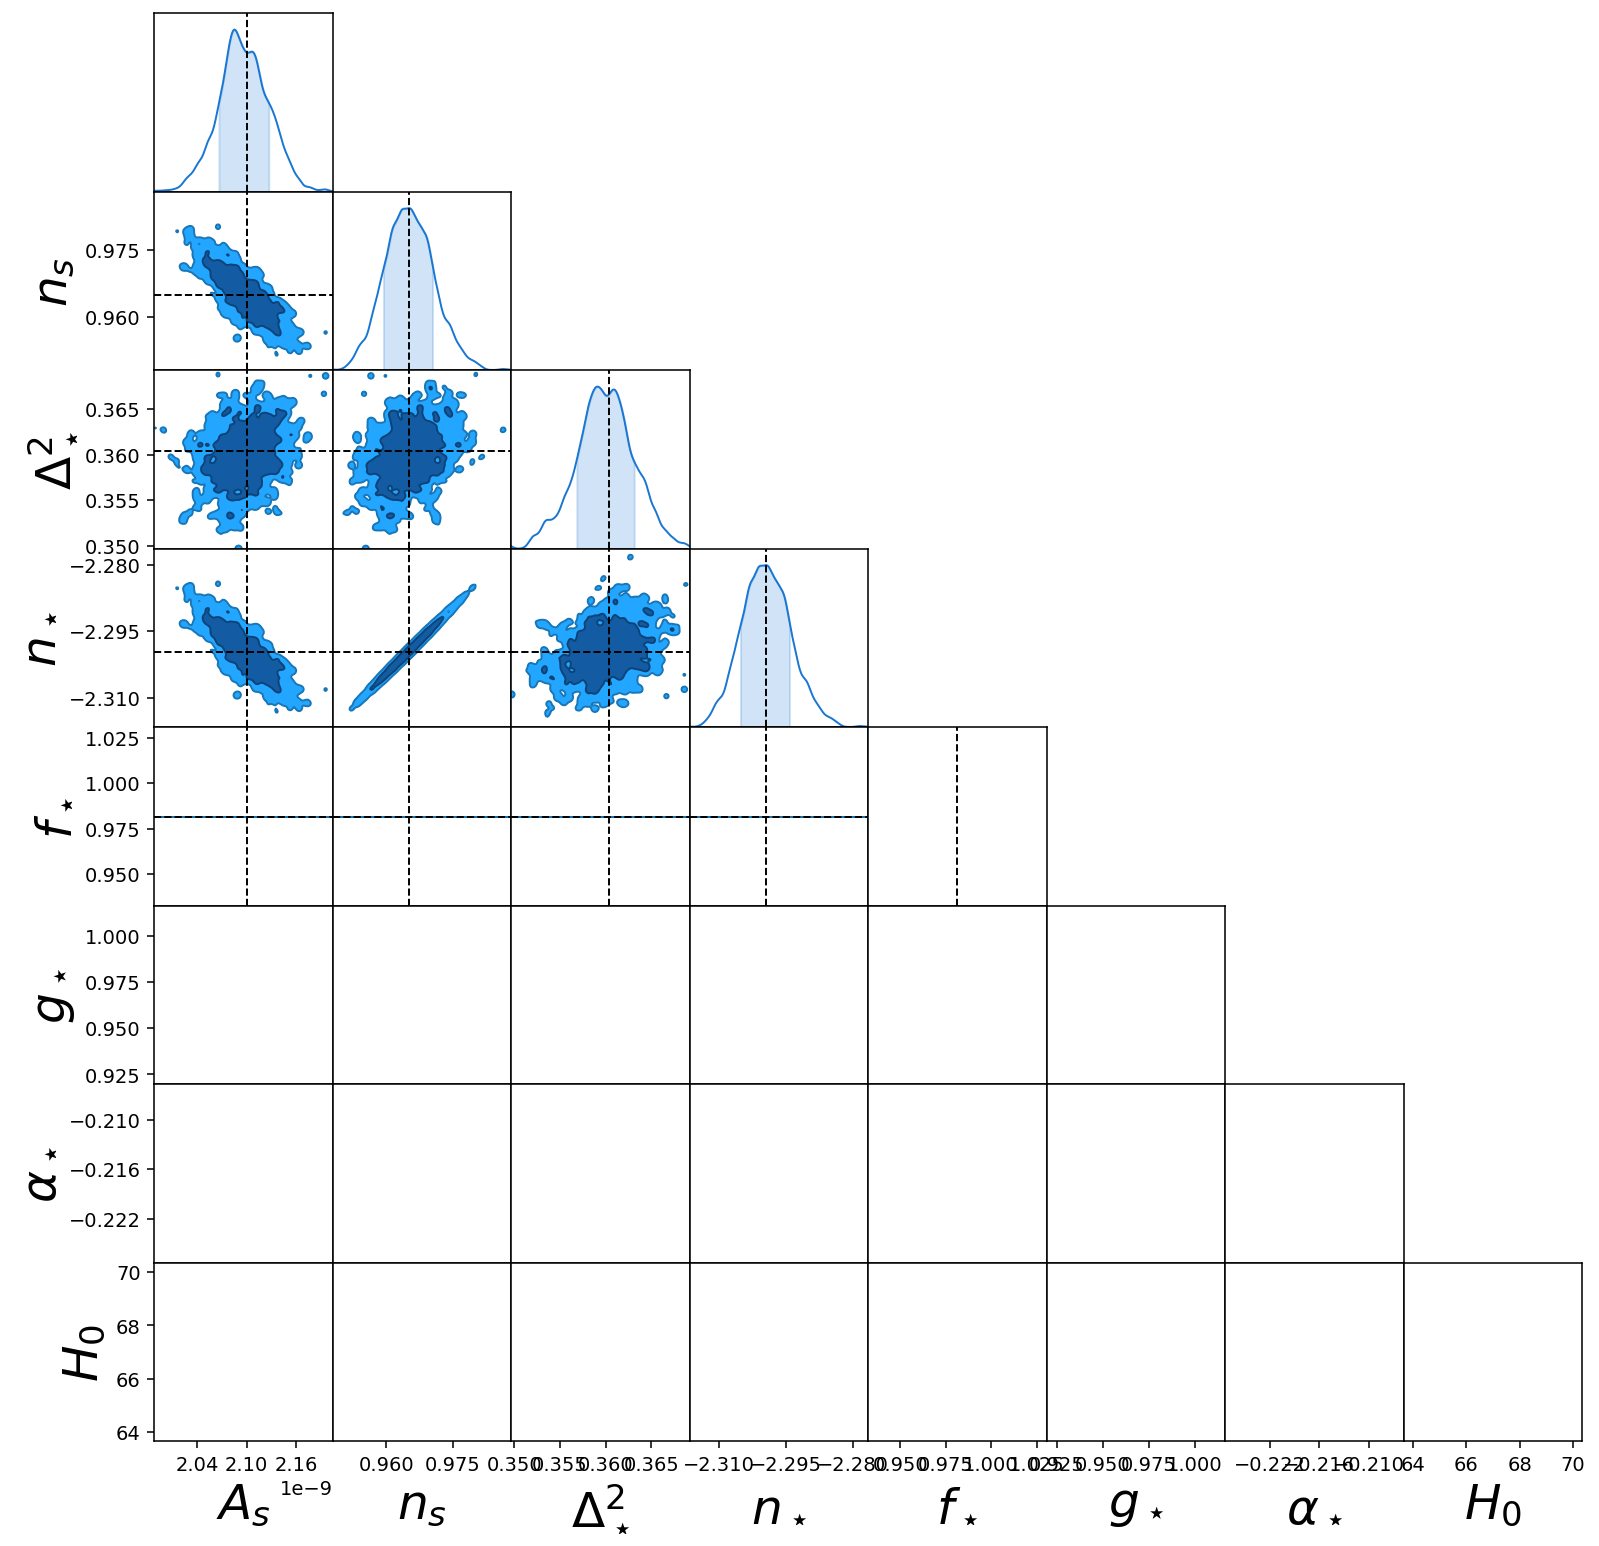

In [14]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

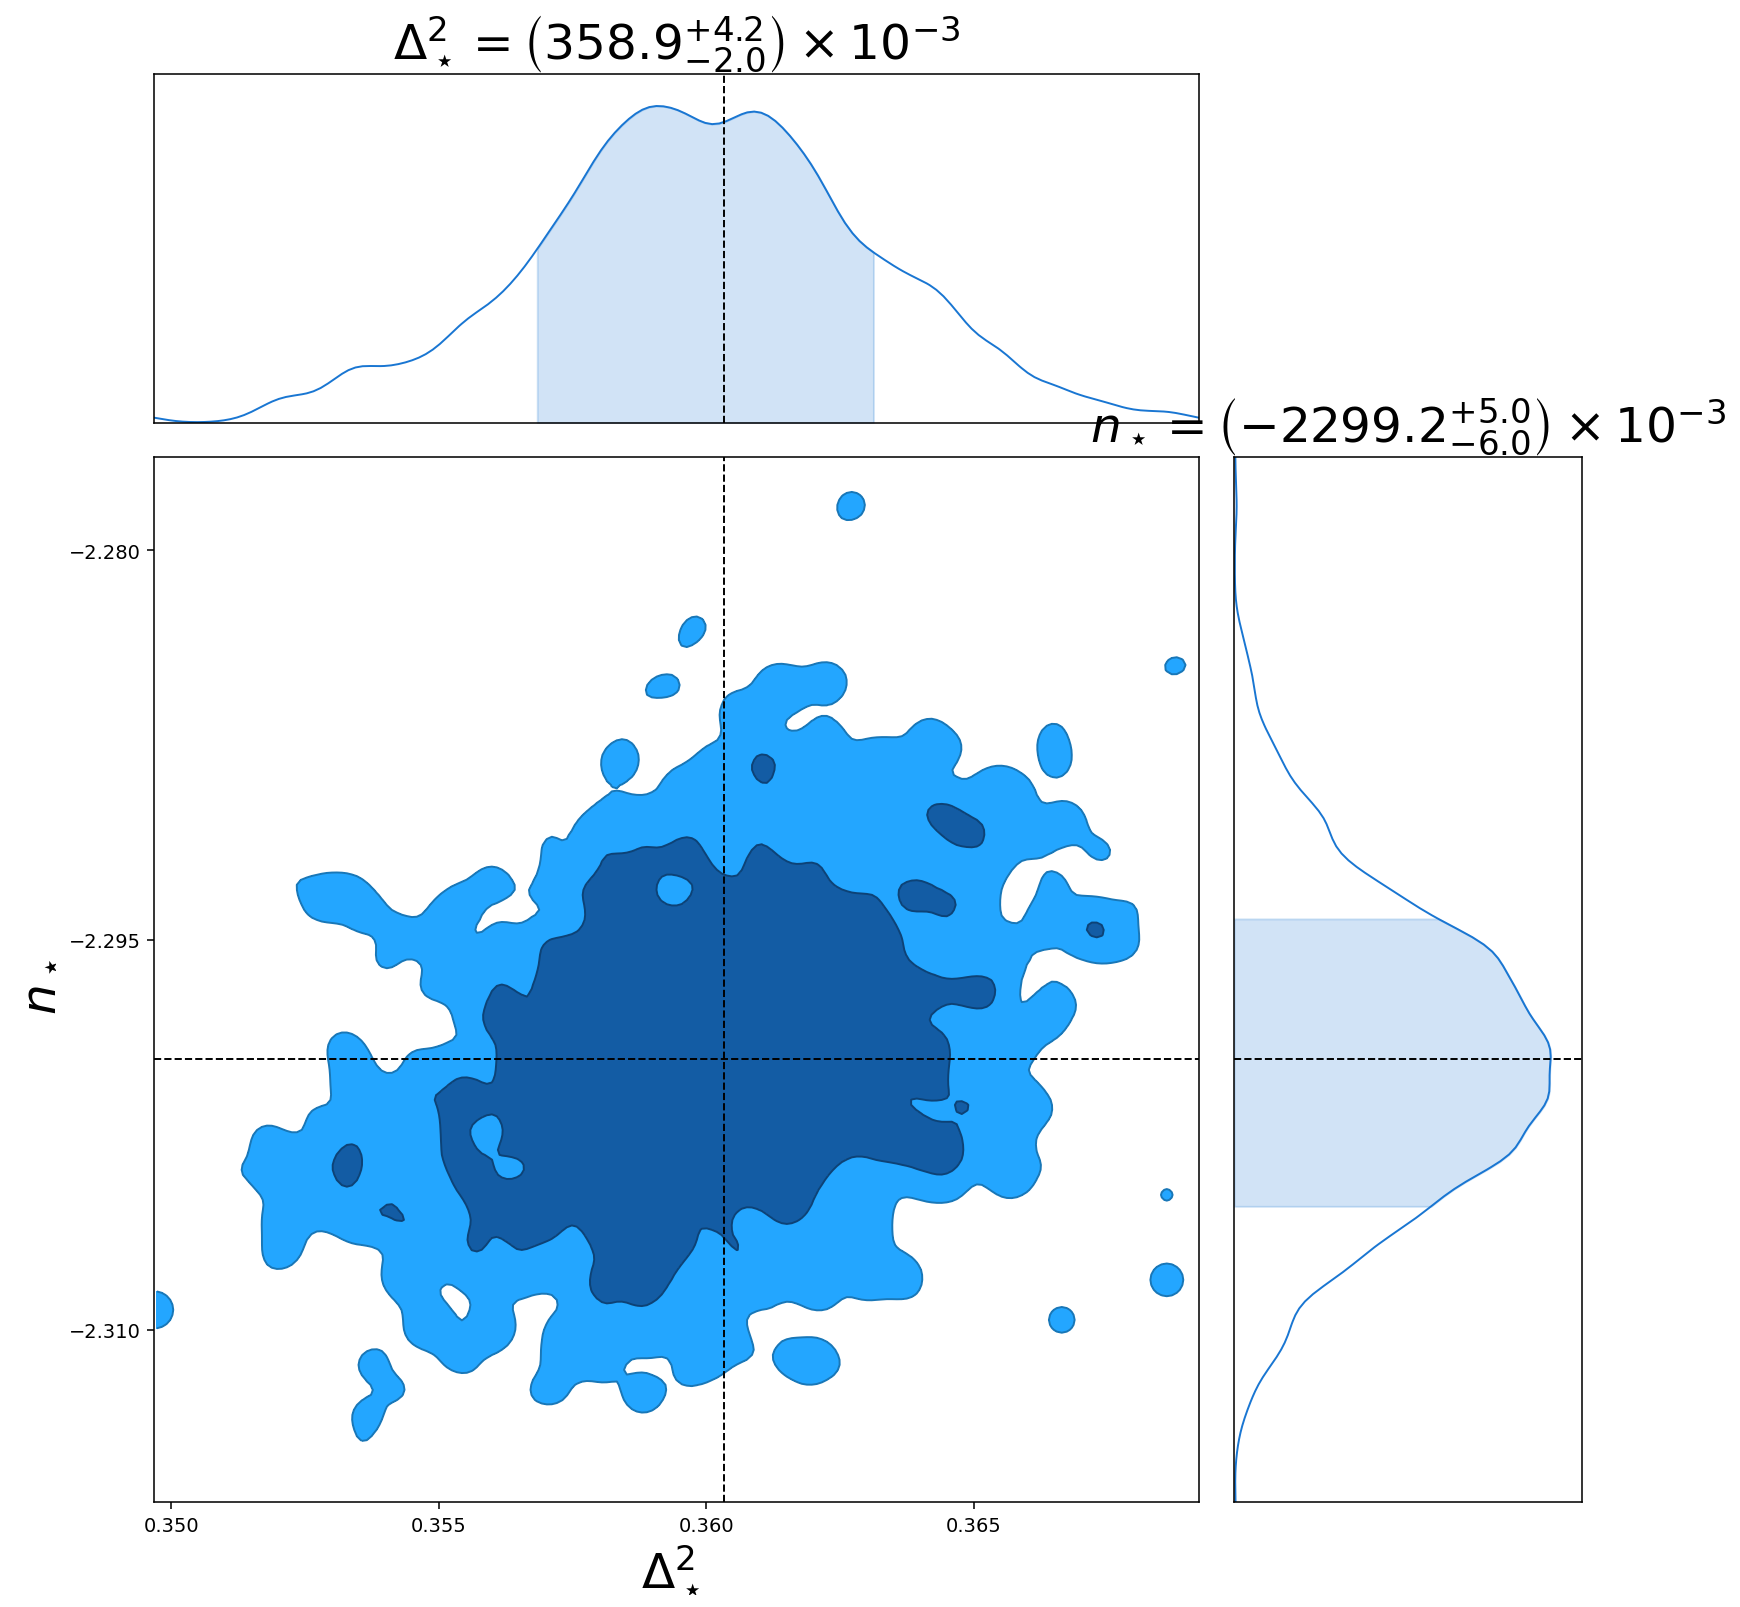

In [13]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [16]:
from corner import corner

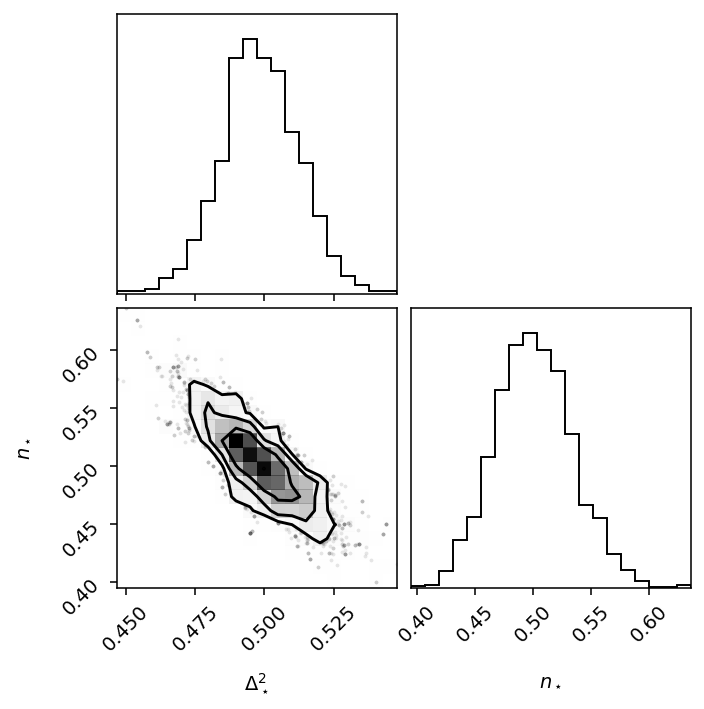

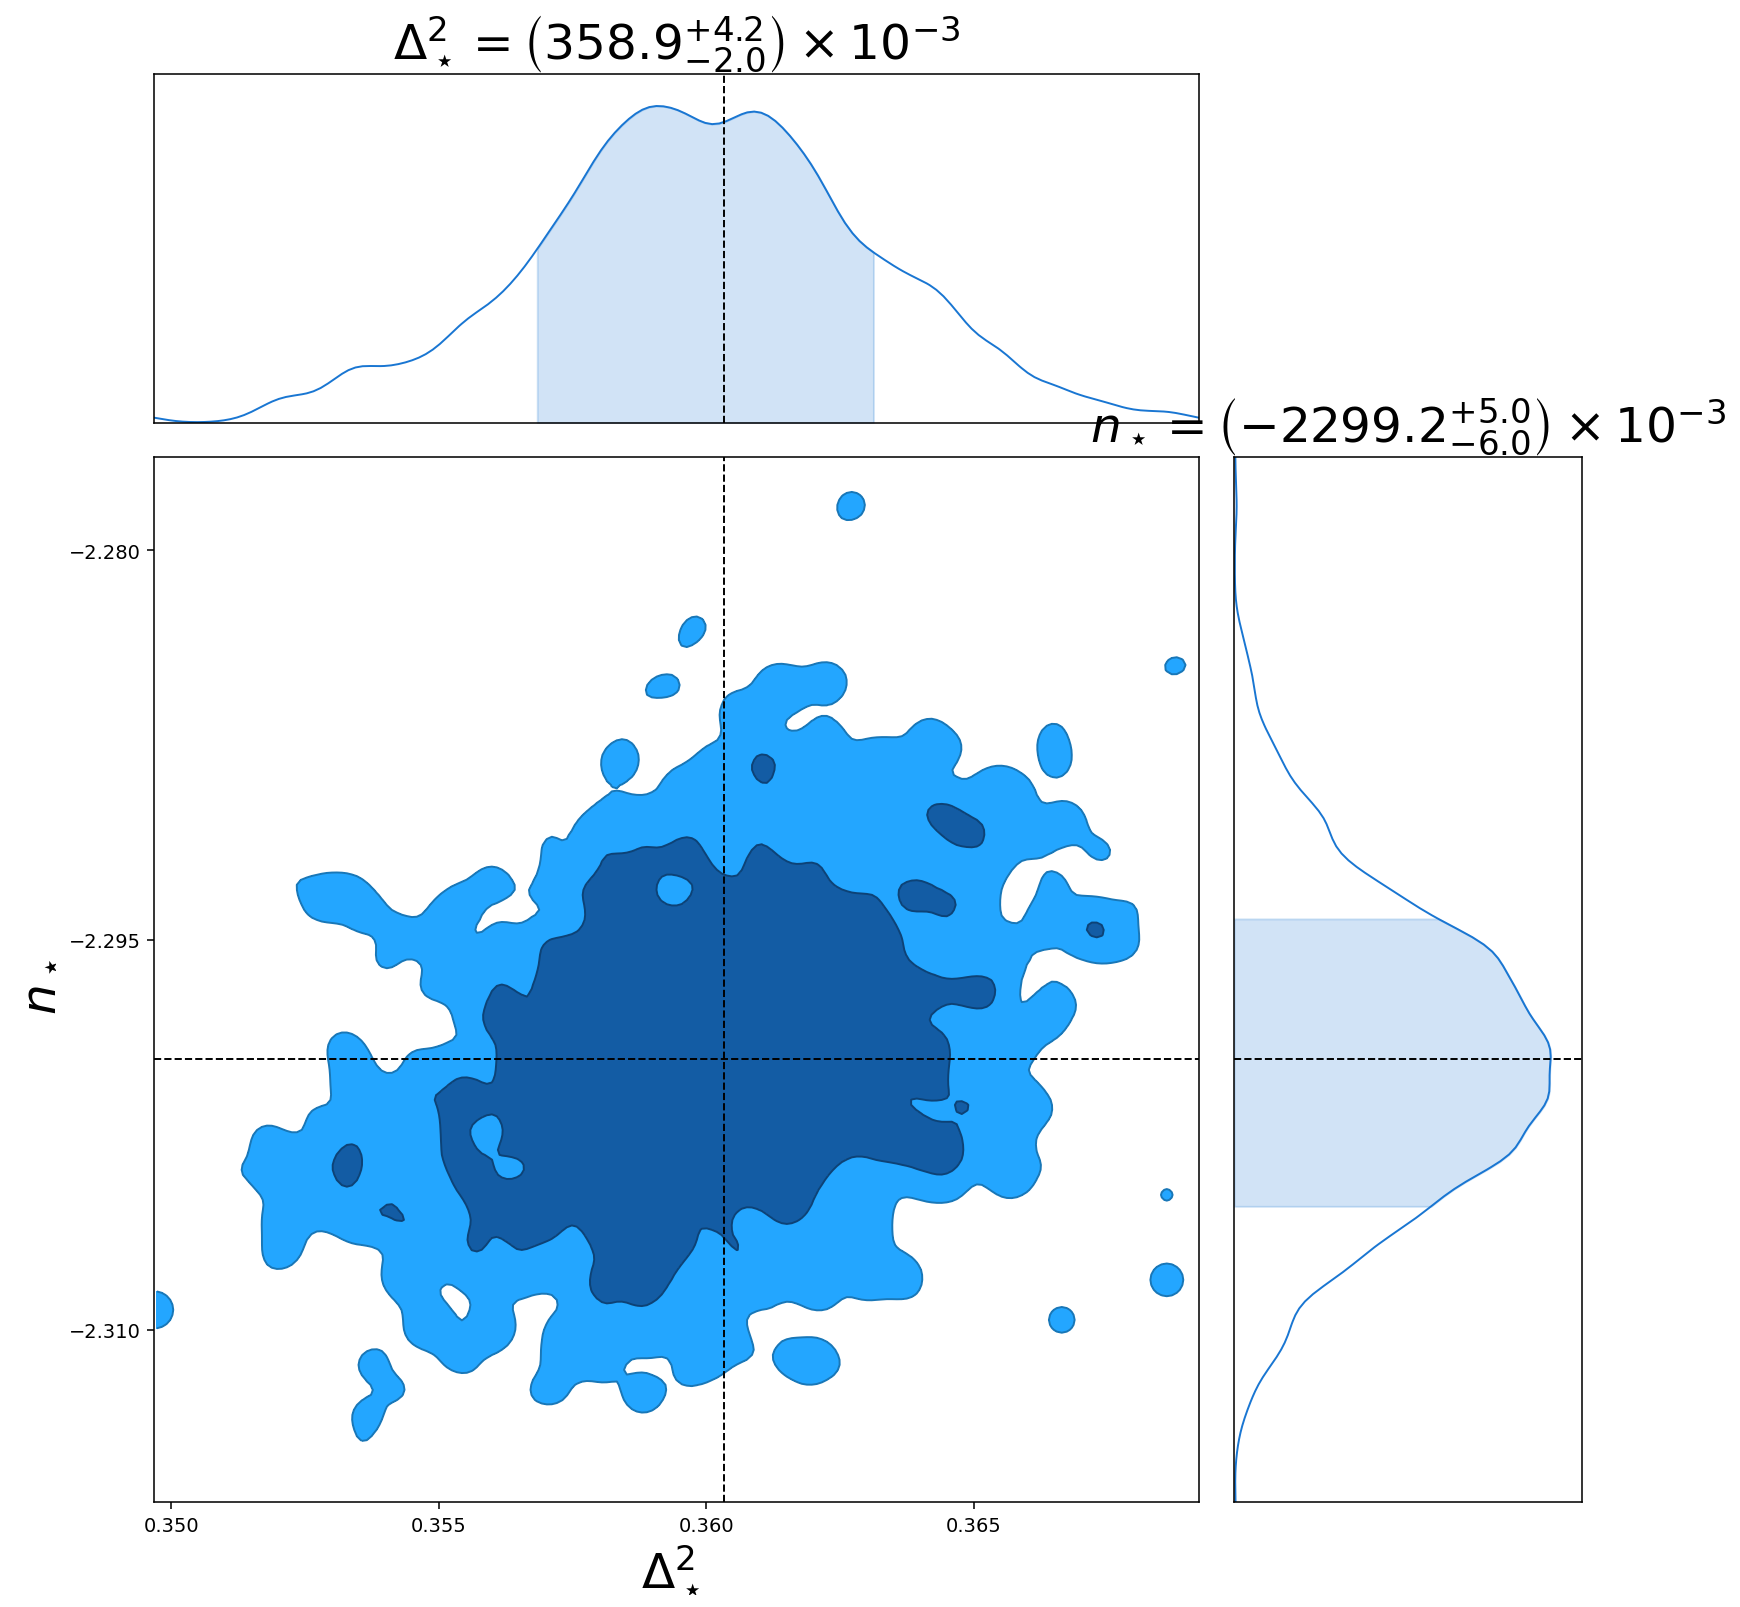

In [21]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [23]:
params_plot, strings_plot = sampler.get_all_params(
            delta_lnprob_cut=50
        )

In [28]:
params_plot[:,:2]

array([[2.07010357e-09, 9.67433676e-01],
       [2.05531172e-09, 9.71512956e-01],
       [2.10546719e-09, 9.64747018e-01],
       ...,
       [2.12022599e-09, 9.62299947e-01],
       [2.03725947e-09, 9.68555620e-01],
       [2.09968777e-09, 9.66998606e-01]])

In [29]:
chain, lnprob, blobs = sampler.get_chain(
            cube=False, delta_lnprob_cut=50
        )

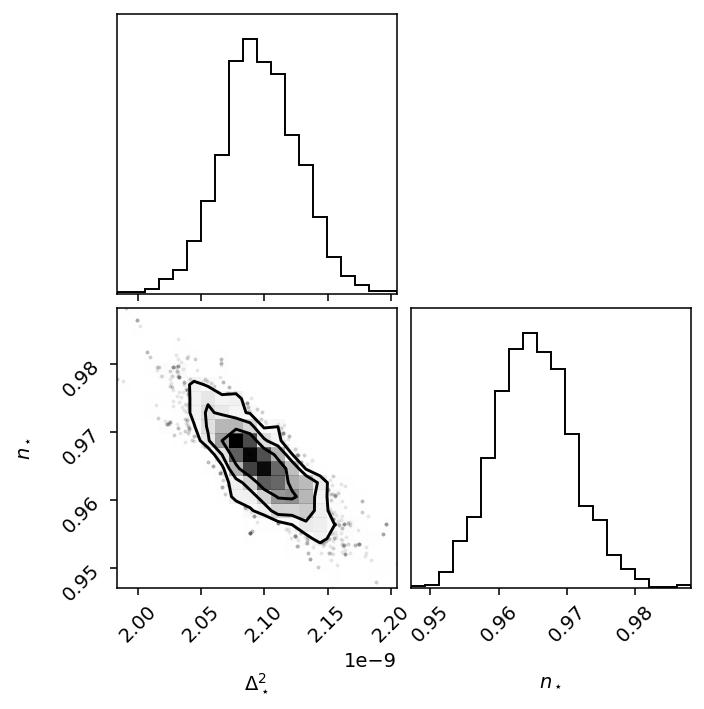

In [32]:
corner(chain, labels=['$\\Delta^2_\\star$','$n_\\star$']);

In [34]:
blobs_full = np.hstack(
    (
        np.vstack(blobs["Delta2_star"]),
        np.vstack(blobs["n_star"]),
        np.vstack(blobs["f_star"]),
        np.vstack(blobs["g_star"]),
        np.vstack(blobs["alpha_star"]),
        np.vstack(blobs["H0"]),
    )
)
# Array for all parameters
all_params = np.hstack((chain, blobs_full))

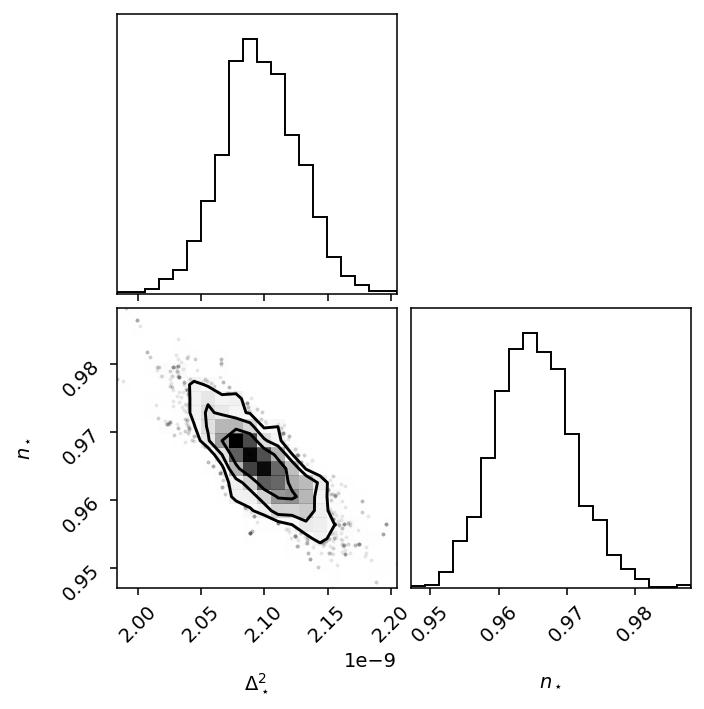

In [36]:
corner(all_params[:,:2], labels=['$\\Delta^2_\\star$','$n_\\star$']);

In [35]:
all_params.shape

(4000, 8)